# Predicción de fuga de clientes

En este notebook construiremos un modelo para predecir la fuga de clientes de una empresa de telecomunicaciones. Este problema se aborda usando un approach de aprendizaje supervisado y se entrena una modelo de clasificación.

Usaremos las siguientes librerias

- pandas
- scikit-learn
- H20

Leer las instrucciones disponibles en el archivo setup/README.md acerca de como instalar las librerias y habilitar el entorno virtual

La libreria de H2O requiere tener instalado java Runtime Environemnt (jre)

Características de H2O

- Puede realizar preprocesamiento de datos. Conversión categórica y continua.
- Se oucpa de la imputación de los valores ausentes.
- La selección de modelos es una buena tabla de clasificación para los modelos.
- Proporciona un código listo para la implementación.
- Da en formato múltiple. MOJO, POJO y binario. Se recomienda MOJO
- Admite GPU para XGBoost
- Funciona tanto en CPU como GPU

In [1]:
import os, sys, glob
import numpy as np
import pandas as pd
import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
dataDir = 'data'
resultsDir = 'results'
modelsDir = 'models'

In [3]:
if not os.path.exists(resultsDir):
    os.mkdir(resultsDir)

if not os.path.exists(modelsDir):
    os.mkdir(modelsDir)

## Iniciamos servidor de h2o

In [4]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\rmunoz\anaconda3\envs\workshop\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\rmunoz\AppData\Local\Temp\tmplqwib33_
  JVM stdout: C:\Users\rmunoz\AppData\Local\Temp\tmplqwib33_\h2o_rmunoz_started_from_python.out
  JVM stderr: C:\Users\rmunoz\AppData\Local\Temp\tmplqwib33_\h2o_rmunoz_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 26 days
H2O_cluster_name:,H2O_from_python_rmunoz_3hsy0d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.20 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


## Cargar datos en H2O

In [5]:
dataFile = os.path.join(dataDir, 'Industria telco Kaggle - analisis de fuga.csv')

dataDF = h2o.import_file(dataFile)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
type(dataDF)

h2o.frame.H2OFrame

In [7]:
dataDF.head()

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.1,1949.4,No
6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [8]:
dataDF.types

{'customerID': 'string',
 'gender': 'enum',
 'SeniorCitizen': 'int',
 'Partner': 'enum',
 'Dependents': 'enum',
 'tenure': 'int',
 'PhoneService': 'enum',
 'MultipleLines': 'enum',
 'InternetService': 'enum',
 'OnlineSecurity': 'enum',
 'OnlineBackup': 'enum',
 'DeviceProtection': 'enum',
 'TechSupport': 'enum',
 'StreamingTV': 'enum',
 'StreamingMovies': 'enum',
 'Contract': 'enum',
 'PaperlessBilling': 'enum',
 'PaymentMethod': 'enum',
 'MonthlyCharges': 'real',
 'TotalCharges': 'real',
 'Churn': 'enum'}

## Preparación de datos

### Separacion entre train y test dataset

In [9]:
trainDF, valDF, testDF = dataDF.split_frame(ratios=[0.7, 0.15])

In [10]:
print(len(trainDF))
print(len(valDF))
print(len(testDF))

4924
1130
989


In [11]:
columnsY = "Churn"

columnsX = dataDF.columns
columnsX.remove("customerID")
columnsX.remove("Churn")

print(columnsX)
print(columnsY)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
Churn


---
## Entrenamiento del modelo de clasificación usando H2O

In [12]:
from h2o.automl import H2OAutoML

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

Parámetros relevantes del método de clasificación de Auto-sklearn

- max_runtime_secs = Limite de tiempo en segundos para buscar modelo óptimo
- max_runtime_secs_per_model = Límite de tiempo en el entrenamiento de un modelo
- max_models = Número máximo de modelos no ensamblados que serán construidos

- include algos = Métodos de clasificación que serán explorados
- exclude algos = Métodos de clasificación que serán excluidos
- nfolds = Usará nfolds para hacer cross-validation
- balance_classes = Determina si se balancearán o no las clases. True o False
- seed = Semilla empleada para los algoritmos que necesitan randomization




Métodos de clasificación disponibles
- Distributed Random Forest (DRF) including both the Random Forest and Extremely Randomized Trees (XRT) models

- Naïve Bayes Classifier

- Gradient Boosting Machine (H2O GBM)

- XGBoost (XGBoost GBM)

- Support Vector Machine (SVM)

- DeepLearning (Fully-connected multi-layer artificial neural network)

- StackedEnsemble

Más info en http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science.html

---
## Modelo 1

Partiremos construyendo un modelo usando solo XGBoost y DRF

In [13]:
model = H2OAutoML(max_runtime_secs=2*60, max_runtime_secs_per_model=30,
                  seed=42, nfolds=0,
                  include_algos=["XGBoost","DRF"], exclude_algos=None, verbosity="info")

In [14]:
model.train(x=columnsX, y=columnsY, training_frame=trainDF, validation_frame=valDF)

AutoML progress: |
22:25:00.561: Project: AutoML_20201123_222500560
22:25:00.562: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:25:00.562: Setting stopping tolerance adaptively based on the training frame: 0.014250856858528702
22:25:00.562: Build control seed: 42
22:25:00.562: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
22:25:00.593: training frame: Frame key: automl_training_py_3_sid_b68e    cols: 21    rows: 4401  chunks: 64    size: 1006286  checksum: 7230359875694459812
22:25:00.593: validation frame: Frame key: py_4_sid_b68e    cols: 21    rows: 1130  chunks: 64    size: 856949  checksum: -4238717688354072600
22:25:00.596: leaderboard frame: Frame key: automl_leaderboard_py_3_sid_b68e    cols: 21    rows: 523  chunks: 64    size: 840551  checksum: 7309686164135754893
22:25:00.596: blending frame: NULL
22:25:00.596: response column: Chu

### Analizamos las métricas de los modelos entrenados

In [15]:
leaderboard = model.leaderboard
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XRT_1_AutoML_20201123_222500,0.807835,0.495933,0.544123,0.24908,0.385132,0.148327
DRF_1_AutoML_20201123_222500,0.7962,0.565122,0.534892,0.270131,0.388632,0.151034


### Calculamos las métricas del clasificador

<img src="images/confusion_matrix.jpg"  width="480">

In [16]:
#model.leader.model_performance(testDF)

Resumen del número de clientes no fugados y fugados en el dataset de test

In [17]:
testDF['Churn'].table()

Churn,Count
No,733
Yes,256


In [18]:
predDF = model.leader.predict(testDF)

predDF.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,No,Yes
No,0.969001,0.0309987
No,0.87,0.13
No,0.896547,0.103453
No,0.982505,0.0174945
Yes,0.518643,0.481357
No,0.993333,0.00666667
Yes,0.359476,0.640524
No,0.956644,0.043356
No,0.923391,0.0766087
No,0.798571,0.201429


Resumen del numero de la predicción del número de clientes no fugados y fugados

In [19]:
predDF['predict'].table()

predict,Count
No,702
Yes,287


## Matriz de confusion

Usaremos como clase positiva los clientes fugados

In [20]:
testY = testDF.as_data_frame()['Churn'].values
predY = predDF.as_data_frame()['predict'].values

In [21]:
labels = ['Fugado', 'No fugado']
cmDF = pd.DataFrame(confusion_matrix(testY, predY, labels=['Yes', 'No']), index=labels, columns=labels)

cmDF

,Fugado,No fugado
Fugado,162,94
No fugado,125,608


Text(30.5, 0.5, 'Actual')

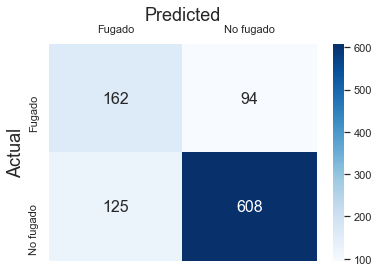

In [22]:
fig, ax = plt.subplots()
sns.heatmap(cmDF, annot=True, annot_kws={"size": 16}, fmt='', cmap=plt.cm.Blues)
plt.tick_params(labelbottom=False, labeltop=True, labelright=False)

ax.set_xlabel('Predicted', fontsize=18)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Actual', fontsize=18)

In [23]:
print(classification_report(testY, predY, labels=['Yes', 'No']))

              precision    recall  f1-score   support

         Yes       0.56      0.63      0.60       256
          No       0.87      0.83      0.85       733

    accuracy                           0.78       989
   macro avg       0.72      0.73      0.72       989
weighted avg       0.79      0.78      0.78       989



---
## Modelo 2

Probaremos todos los métodos de clasificación, excepto DeepLearning

In [24]:
model = H2OAutoML(max_runtime_secs=5*60, max_runtime_secs_per_model=30,
                  seed=42, nfolds=0,
                  exclude_algos=["DeepLearning"], verbosity="info")

In [25]:
model.train(x=columnsX, y=columnsY, training_frame=trainDF, validation_frame=valDF)

AutoML progress: |
22:25:16.138: Project: AutoML_20201123_222516138
22:25:16.138: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:25:16.138: Setting stopping tolerance adaptively based on the training frame: 0.014250856858528702
22:25:16.138: Build control seed: 42
22:25:16.138: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
22:25:16.183: training frame: Frame key: automl_training_py_3_sid_b68e    cols: 21    rows: 4401  chunks: 64    size: 1006286  checksum: 7230359875694459812
22:25:16.183: validation frame: Frame key: py_4_sid_b68e    cols: 21    rows: 1130  chunks: 64    size: 856949  checksum: -4238717688354072600
22:25:16.184: leaderboard frame: Frame key: automl_leaderboard_py_3_sid_b68e    cols: 21    rows: 523  chunks: 64    size: 840551  checksum: 7309686164135754893
22:25:16.184: blending frame: NULL
22:25:16.184: response column: Chu

### Analizamos las métricas de los modelos entrenados

In [26]:
leaderboard = model.leaderboard
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_5_AutoML_20201123_222516,0.823358,0.424653,0.5748,0.25079,0.375999,0.141376
GBM_1_AutoML_20201123_222516,0.820579,0.431058,0.556754,0.245182,0.379708,0.144178
GLM_1_AutoML_20201123_222516,0.81727,0.429789,0.565491,0.238245,0.377852,0.142772
GBM_grid__1_AutoML_20201123_222516_model_10,0.815511,0.434253,0.568632,0.266353,0.379953,0.144364
GBM_2_AutoML_20201123_222516,0.815271,0.440152,0.542528,0.24984,0.384658,0.147962
GBM_grid__1_AutoML_20201123_222516_model_4,0.813722,0.437458,0.562078,0.239505,0.382291,0.146146
GBM_grid__1_AutoML_20201123_222516_model_6,0.812992,0.437839,0.554481,0.247131,0.382528,0.146328
GBM_grid__1_AutoML_20201123_222516_model_9,0.812113,0.448727,0.529632,0.248771,0.386858,0.149659
GBM_4_AutoML_20201123_222516,0.808554,0.454073,0.531894,0.262055,0.389184,0.151464
GBM_grid__1_AutoML_20201123_222516_model_3,0.808214,0.462719,0.523306,0.259986,0.393008,0.154455


### Calculamos las métricas del clasificador

In [27]:
#model.leader.model_performance(testDF)

In [28]:
predDF = model.leader.predict(testDF)

predDF.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,No,Yes
No,0.980206,0.0197943
No,0.833269,0.166731
No,0.94795,0.0520498
No,0.966318,0.0336823
Yes,0.589995,0.410005
No,0.983209,0.0167907
Yes,0.350321,0.649679
No,0.967965,0.0320347
No,0.936585,0.063415
No,0.849281,0.150719


In [29]:
testY = testDF.as_data_frame()['Churn'].values
predY = predDF.as_data_frame()['predict'].values

In [30]:
labels = ['Fugado', 'No fugado']
cmDF = pd.DataFrame(confusion_matrix(testY, predY, labels=['Yes', 'No']), index=labels, columns=labels)

cmDF

,Fugado,No fugado
Fugado,194,62
No fugado,172,561


Text(30.5, 0.5, 'Actual')

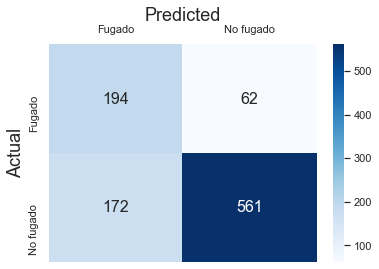

In [31]:
fig, ax = plt.subplots()
sns.heatmap(cmDF, annot=True, annot_kws={"size": 16}, fmt='', cmap=plt.cm.Blues)
plt.tick_params(labelbottom=False, labeltop=True, labelright=False)

ax.set_xlabel('Predicted', fontsize=18)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Actual', fontsize=18)

In [32]:
print(classification_report(testY, predY, labels=['Yes', 'No']))

              precision    recall  f1-score   support

         Yes       0.53      0.76      0.62       256
          No       0.90      0.77      0.83       733

    accuracy                           0.76       989
   macro avg       0.72      0.76      0.73       989
weighted avg       0.80      0.76      0.77       989



---
## Modelo 3

Probaremos todos los métodos de clasificación, excepto DeepLearning

In [33]:
model = H2OAutoML(max_runtime_secs=5*60, max_runtime_secs_per_model=30,
                  seed=42, nfolds=5,
                  exclude_algos=["DeepLearning"], verbosity="info")

In [34]:
model.train(x=columnsX, y=columnsY, training_frame=trainDF, validation_frame=valDF)

AutoML progress: |
22:27:27.547: Project: AutoML_20201123_222727547
22:27:27.559: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
22:27:27.559: Setting stopping tolerance adaptively based on the training frame: 0.014250856858528702
22:27:27.559: Build control seed: 42
22:27:27.559: training frame: Frame key: automl_training_py_3_sid_b68e    cols: 21    rows: 4924  chunks: 64    size: 981531  checksum: 6702015151869119143
22:27:27.559: validation frame: Frame key: py_4_sid_b68e    cols: 21    rows: 1130  chunks: 64    size: 856949  checksum: -4238717688354072600
22:27:27.559: leaderboard frame: NULL
22:27:27.559: blending frame: NULL
22:27:27.559: response column: Churn
22:27:27.559: fold column: null
22:27:27.559: weights column: null
22:27:27.559: AutoML: XGBoost is not availabl

### Analizamos las métricas de los modelos entrenados

In [35]:
leaderboard = model.leaderboard
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20201123_222727,0.851433,0.418719,0.663261,0.227383,0.36728,0.134895
StackedEnsemble_AllModels_AutoML_20201123_222727,0.851416,0.419017,0.664486,0.237347,0.367387,0.134973
GBM_grid__1_AutoML_20201123_222727_model_14,0.850835,0.410444,0.663235,0.228781,0.365494,0.133586
GBM_5_AutoML_20201123_222727,0.849527,0.4118,0.662034,0.231697,0.366155,0.13407
GLM_1_AutoML_20201123_222727,0.84837,0.413748,0.656797,0.237547,0.366945,0.134649
GBM_grid__1_AutoML_20201123_222727_model_4,0.845321,0.417218,0.64951,0.238497,0.369011,0.136169
GBM_1_AutoML_20201123_222727,0.844664,0.419477,0.643819,0.236525,0.37027,0.1371
GBM_2_AutoML_20201123_222727,0.843671,0.420845,0.647821,0.229172,0.370983,0.137628
GBM_grid__1_AutoML_20201123_222727_model_15,0.843522,0.419748,0.647095,0.235261,0.370397,0.137194
GBM_grid__1_AutoML_20201123_222727_model_6,0.843035,0.420143,0.644972,0.232932,0.370268,0.137099


### Calculamos las métricas del clasificador

In [36]:
#model.leader.model_performance(testDF)

In [37]:
predDF = model.leader.predict(testDF)

predDF.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,No,Yes
No,0.941374,0.0586262
No,0.875643,0.124357
No,0.930413,0.0695872
No,0.937794,0.0622065
Yes,0.715719,0.284281
No,0.945229,0.0547713
Yes,0.418122,0.581878
No,0.943593,0.0564073
No,0.920692,0.0793084
No,0.868289,0.131711


In [38]:
testY = testDF.as_data_frame()['Churn'].values
predY = predDF.as_data_frame()['predict'].values

In [39]:
labels = ['Fugado', 'No fugado']
cmDF = pd.DataFrame(confusion_matrix(testY, predY, labels=['Yes', 'No']), index=labels, columns=labels)

cmDF

,Fugado,No fugado
Fugado,186,70
No fugado,166,567


Text(30.5, 0.5, 'Actual')

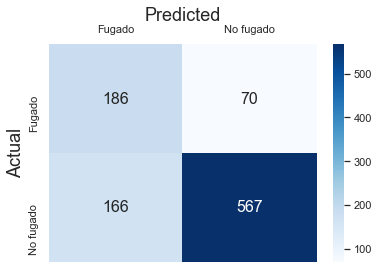

In [40]:
fig, ax = plt.subplots()
sns.heatmap(cmDF, annot=True, annot_kws={"size": 16}, fmt='', cmap=plt.cm.Blues)
plt.tick_params(labelbottom=False, labeltop=True, labelright=False)

ax.set_xlabel('Predicted', fontsize=18)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Actual', fontsize=18)

In [41]:
print(classification_report(testY, predY, labels=['Yes', 'No']))

              precision    recall  f1-score   support

         Yes       0.53      0.73      0.61       256
          No       0.89      0.77      0.83       733

    accuracy                           0.76       989
   macro avg       0.71      0.75      0.72       989
weighted avg       0.80      0.76      0.77       989



## Selecionamos un modelo en particular del leaderboard

In [42]:
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20201123_222727,0.851433,0.418719,0.663261,0.227383,0.36728,0.134895
StackedEnsemble_AllModels_AutoML_20201123_222727,0.851416,0.419017,0.664486,0.237347,0.367387,0.134973
GBM_grid__1_AutoML_20201123_222727_model_14,0.850835,0.410444,0.663235,0.228781,0.365494,0.133586
GBM_5_AutoML_20201123_222727,0.849527,0.4118,0.662034,0.231697,0.366155,0.13407
GLM_1_AutoML_20201123_222727,0.84837,0.413748,0.656797,0.237547,0.366945,0.134649
GBM_grid__1_AutoML_20201123_222727_model_4,0.845321,0.417218,0.64951,0.238497,0.369011,0.136169
GBM_1_AutoML_20201123_222727,0.844664,0.419477,0.643819,0.236525,0.37027,0.1371
GBM_2_AutoML_20201123_222727,0.843671,0.420845,0.647821,0.229172,0.370983,0.137628
GBM_grid__1_AutoML_20201123_222727_model_15,0.843522,0.419748,0.647095,0.235261,0.370397,0.137194
GBM_grid__1_AutoML_20201123_222727_model_6,0.843035,0.420143,0.644972,0.232932,0.370268,0.137099


In [43]:
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:, 0])
model_ids

['StackedEnsemble_BestOfFamily_AutoML_20201123_222727',
 'StackedEnsemble_AllModels_AutoML_20201123_222727',
 'GBM_grid__1_AutoML_20201123_222727_model_14',
 'GBM_5_AutoML_20201123_222727',
 'GLM_1_AutoML_20201123_222727',
 'GBM_grid__1_AutoML_20201123_222727_model_4',
 'GBM_1_AutoML_20201123_222727',
 'GBM_2_AutoML_20201123_222727',
 'GBM_grid__1_AutoML_20201123_222727_model_15',
 'GBM_grid__1_AutoML_20201123_222727_model_6',
 'GBM_grid__1_AutoML_20201123_222727_model_10',
 'GBM_grid__1_AutoML_20201123_222727_model_2',
 'GBM_grid__1_AutoML_20201123_222727_model_8',
 'GBM_grid__1_AutoML_20201123_222727_model_9',
 'GBM_3_AutoML_20201123_222727',
 'GBM_grid__1_AutoML_20201123_222727_model_5',
 'GBM_grid__1_AutoML_20201123_222727_model_12',
 'GBM_4_AutoML_20201123_222727',
 'GBM_grid__1_AutoML_20201123_222727_model_11',
 'GBM_grid__1_AutoML_20201123_222727_model_7',
 'XRT_1_AutoML_20201123_222727',
 'DRF_1_AutoML_20201123_222727',
 'GBM_grid__1_AutoML_20201123_222727_model_3',
 'GBM_grid_

In [50]:
gbm_model_ids = []
for model_id in model_ids:
    if "GBM" in model_id:
        gbm_model_ids.append(model_id)

print(gbm_model_ids)

['GBM_grid__1_AutoML_20201123_222727_model_14', 'GBM_5_AutoML_20201123_222727', 'GBM_grid__1_AutoML_20201123_222727_model_4', 'GBM_1_AutoML_20201123_222727', 'GBM_2_AutoML_20201123_222727', 'GBM_grid__1_AutoML_20201123_222727_model_15', 'GBM_grid__1_AutoML_20201123_222727_model_6', 'GBM_grid__1_AutoML_20201123_222727_model_10', 'GBM_grid__1_AutoML_20201123_222727_model_2', 'GBM_grid__1_AutoML_20201123_222727_model_8', 'GBM_grid__1_AutoML_20201123_222727_model_9', 'GBM_3_AutoML_20201123_222727', 'GBM_grid__1_AutoML_20201123_222727_model_5', 'GBM_grid__1_AutoML_20201123_222727_model_12', 'GBM_4_AutoML_20201123_222727', 'GBM_grid__1_AutoML_20201123_222727_model_11', 'GBM_grid__1_AutoML_20201123_222727_model_7', 'GBM_grid__1_AutoML_20201123_222727_model_3', 'GBM_grid__1_AutoML_20201123_222727_model_13', 'GBM_grid__1_AutoML_20201123_222727_model_1']


In [51]:
model_chosen_id = gbm_model_ids[0]
print(model_chosen_id)

GBM_grid__1_AutoML_20201123_222727_model_14


In [52]:
gbm_model = h2o.get_model(model_chosen_id)

In [53]:
gbm_model.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_grid__1_AutoML_20201123_222727_model_14',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_grid__1_AutoML_20201123_222727_model_14'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_py_3_sid_b68e',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_py_3_sid_b68e'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_py_3_sid_b68e',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_py_3_sid_b68e'}},
 'validation_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'py_4_sid_b68e',
  

In [54]:
print(gbm_model)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20201123_222727_model_14


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,49.00,49.00,17334.00,6.00,10.00,7.51,20.00,28.00,23.45




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12142551460317828
RMSE: 0.34846164007416697
LogLoss: 0.37625437059763356
Mean Per-Class Error: 0.1983419019335324
AUC: 0.879872907311262
AUCPR: 0.7202574855757942
Gini: 0.759745814622524

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29746231791651345: 


,,No,Yes,Error,Rate
0,No,2834.00,780.00,0.2158,(780.0/3614.0)
1,Yes,241.00,1069.00,0.184,(241.0/1310.0)
2,Total,3075.00,1849.00,0.2074,(1021.0/4924.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.30,0.68,231.00
1,max f2,0.17,0.78,292.00
2,max f0point5,0.54,0.68,130.00
3,max accuracy,0.50,0.82,146.00
4,max precision,0.90,1.00,0.00
5,max recall,0.02,1.00,388.00
6,max specificity,0.90,1.00,0.00
7,max absolute_mcc,0.39,0.55,191.00
8,max min_per_class_accuracy,0.31,0.79,226.00
9,max mean_per_class_accuracy,0.25,0.80,252.00



Gains/Lift Table: Avg response rate: 26.60 %, avg score: 26.56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.85,3.46,3.46,0.92,0.87,0.92,0.87,0.04,0.04,245.81,245.81,0.03
1,2,0.02,0.83,3.30,3.38,0.88,0.84,0.90,0.86,0.03,0.07,229.85,237.91,0.07
2,3,0.03,0.81,3.54,3.44,0.94,0.82,0.91,0.85,0.04,0.11,254.19,243.52,0.10
3,4,0.04,0.79,3.35,3.42,0.89,0.80,0.91,0.84,0.03,0.14,235.02,241.53,0.13
4,5,0.05,0.77,3.38,3.41,0.90,0.78,0.91,0.83,0.03,0.17,238.29,240.88,0.16
5,6,0.10,0.68,2.68,3.04,0.71,0.72,0.81,0.77,0.13,0.31,167.83,204.35,0.28
6,7,0.15,0.59,2.59,2.89,0.69,0.63,0.77,0.73,0.13,0.43,159.28,189.41,0.39
7,8,0.20,0.52,2.11,2.70,0.56,0.56,0.72,0.68,0.11,0.54,110.86,169.79,0.46
8,9,0.30,0.38,1.75,2.38,0.47,0.45,0.63,0.60,0.17,0.71,74.95,138.20,0.56
9,10,0.40,0.27,1.27,2.10,0.34,0.32,0.56,0.53,0.13,0.84,26.56,110.26,0.60




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13875501475834323
RMSE: 0.3724983419538176
LogLoss: 0.4295672112749252
Mean Per-Class Error: 0.2400082208946408
AUC: 0.8358854023249968
AUCPR: 0.6458841328072655
Gini: 0.6717708046499935

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29865848604789125: 


,,No,Yes,Error,Rate
0,No,645.00,182.00,0.2201,(182.0/827.0)
1,Yes,79.00,224.00,0.2607,(79.0/303.0)
2,Total,724.00,406.00,0.231,(261.0/1130.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.30,0.63,209.00
1,max f2,0.14,0.74,295.00
2,max f0point5,0.49,0.65,126.00
3,max accuracy,0.49,0.81,126.00
4,max precision,0.89,1.00,0.00
5,max recall,0.02,1.00,384.00
6,max specificity,0.89,1.00,0.00
7,max absolute_mcc,0.48,0.49,132.00
8,max min_per_class_accuracy,0.28,0.76,218.00
9,max mean_per_class_accuracy,0.28,0.76,218.00



Gains/Lift Table: Avg response rate: 26.81 %, avg score: 25.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.85,2.49,2.49,0.67,0.86,0.67,0.86,0.03,0.03,148.62,148.62,0.02
1,2,0.02,0.83,3.73,3.08,1.00,0.84,0.83,0.85,0.04,0.06,272.94,208.08,0.06
2,3,0.03,0.81,3.39,3.18,0.91,0.82,0.85,0.84,0.03,0.10,239.03,218.09,0.09
3,4,0.04,0.77,2.49,3.00,0.67,0.79,0.80,0.83,0.03,0.12,148.62,199.97,0.11
4,5,0.05,0.76,3.05,3.01,0.82,0.76,0.81,0.82,0.03,0.15,205.13,200.97,0.14
5,6,0.10,0.66,2.80,2.90,0.75,0.72,0.78,0.77,0.14,0.29,179.70,190.43,0.26
6,7,0.15,0.56,2.09,2.63,0.56,0.60,0.71,0.71,0.11,0.40,109.37,163.25,0.34
7,8,0.20,0.49,2.40,2.57,0.64,0.53,0.69,0.67,0.12,0.51,139.75,157.43,0.43
8,9,0.30,0.35,1.35,2.17,0.36,0.43,0.58,0.59,0.14,0.65,35.31,116.72,0.48
9,10,0.40,0.26,1.22,1.93,0.33,0.30,0.52,0.52,0.12,0.77,22.11,93.07,0.51




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13358620465132356
RMSE: 0.36549446596538715
LogLoss: 0.41044428177940184
Mean Per-Class Error: 0.22558371388620158
AUC: 0.8508352801024008
AUCPR: 0.6632353963131369
Gini: 0.7016705602048017

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27022171115226423: 


,,No,Yes,Error,Rate
0,No,2708.00,906.00,0.2507,(906.0/3614.0)
1,Yes,271.00,1039.00,0.2069,(271.0/1310.0)
2,Total,2979.00,1945.00,0.239,(1177.0/4924.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.27,0.64,236.00
1,max f2,0.18,0.76,282.00
2,max f0point5,0.48,0.64,147.00
3,max accuracy,0.48,0.81,147.00
4,max precision,0.81,0.93,25.00
5,max recall,0.01,1.00,397.00
6,max specificity,0.90,1.00,0.00
7,max absolute_mcc,0.42,0.49,173.00
8,max min_per_class_accuracy,0.29,0.76,227.00
9,max mean_per_class_accuracy,0.25,0.77,248.00



Gains/Lift Table: Avg response rate: 26.60 %, avg score: 26.64 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.85,3.23,3.23,0.86,0.87,0.86,0.87,0.03,0.03,223.25,223.25,0.03
1,2,0.02,0.83,3.45,3.34,0.92,0.84,0.89,0.85,0.03,0.07,245.19,234.11,0.06
2,3,0.03,0.81,3.76,3.48,1.00,0.82,0.93,0.84,0.04,0.10,275.88,247.94,0.10
3,4,0.04,0.79,2.61,3.26,0.69,0.80,0.87,0.83,0.03,0.13,160.81,226.27,0.12
4,5,0.05,0.77,2.41,3.09,0.64,0.78,0.82,0.82,0.02,0.15,140.56,208.92,0.14
5,6,0.10,0.68,2.58,2.84,0.69,0.72,0.75,0.77,0.13,0.28,158.23,183.62,0.25
6,7,0.15,0.60,2.35,2.68,0.63,0.64,0.71,0.73,0.12,0.40,135.31,167.54,0.34
7,8,0.20,0.52,2.14,2.54,0.57,0.56,0.68,0.68,0.11,0.51,113.91,154.15,0.42
8,9,0.30,0.38,1.65,2.24,0.44,0.45,0.60,0.60,0.16,0.67,65.02,124.46,0.51
9,10,0.40,0.27,1.24,1.99,0.33,0.31,0.53,0.53,0.12,0.80,24.28,99.39,0.54




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.78371054,0.03170091,0.8172589,0.7522843,0.7573604,0.8172589,0.7743902
1,auc,0.85123503,0.009225375,0.85209954,0.85185355,0.8438531,0.8657476,0.8426214
2,aucpr,0.66632247,0.031934146,0.6522925,0.66945845,0.6499096,0.72016466,0.6397872
3,err,0.21628946,0.03170091,0.18274112,0.24771574,0.2426396,0.18274112,0.22560975
4,err_count,213.0,31.208973,180.0,244.0,239.0,180.0,222.0
5,f0point5,0.60564905,0.038861874,0.6309148,0.5818001,0.5800821,0.6618182,0.57363015
6,f1,0.65295523,0.011461363,0.64,0.6573034,0.65412444,0.6691176,0.6442308
7,f2,0.71314794,0.047419615,0.64935064,0.75532603,0.7498341,0.67657995,0.7346491
8,lift_top_group,3.2512405,0.48144278,3.2295082,2.471326,3.2591913,3.6891387,3.607038
9,logloss,0.41044462,0.013085844,0.397906,0.42016083,0.42570406,0.39637926,0.4120729



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-23 22:28:05,19.322 sec,0.00,0.44,0.58,0.50,0.27,1.00,0.73,0.44,0.58,0.50,0.27,1.00,0.73
1,,2020-11-23 22:28:05,19.341 sec,5.00,0.40,0.49,0.85,0.67,3.38,0.20,0.41,0.50,0.82,0.61,3.11,0.25
2,,2020-11-23 22:28:05,19.362 sec,10.00,0.38,0.44,0.86,0.68,3.38,0.21,0.39,0.46,0.82,0.63,3.11,0.22
3,,2020-11-23 22:28:05,19.385 sec,15.00,0.37,0.42,0.86,0.69,3.38,0.20,0.38,0.45,0.83,0.64,3.11,0.22
4,,2020-11-23 22:28:05,19.408 sec,20.00,0.36,0.41,0.87,0.70,3.48,0.19,0.38,0.44,0.83,0.64,3.42,0.25
5,,2020-11-23 22:28:05,19.430 sec,25.00,0.36,0.40,0.87,0.70,3.38,0.21,0.38,0.43,0.83,0.65,3.42,0.26
6,,2020-11-23 22:28:05,19.452 sec,30.00,0.35,0.39,0.87,0.71,3.46,0.19,0.37,0.43,0.83,0.65,3.44,0.26
7,,2020-11-23 22:28:05,19.473 sec,35.00,0.35,0.39,0.87,0.71,3.38,0.21,0.37,0.43,0.84,0.65,2.87,0.21
8,,2020-11-23 22:28:05,19.497 sec,40.00,0.35,0.38,0.88,0.71,3.53,0.19,0.37,0.43,0.84,0.65,3.20,0.25
9,,2020-11-23 22:28:05,19.521 sec,45.00,0.35,0.38,0.88,0.72,3.38,0.21,0.37,0.43,0.83,0.65,2.80,0.24



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,354.00,1.00,0.21
1,Contract,337.44,0.95,0.20
2,InternetService,172.39,0.49,0.10
3,OnlineSecurity,165.48,0.47,0.10
4,PaymentMethod,142.73,0.40,0.09
5,TotalCharges,141.82,0.40,0.09
6,MonthlyCharges,89.32,0.25,0.05
7,TechSupport,74.42,0.21,0.04
8,DeviceProtection,30.24,0.09,0.02
9,StreamingTV,28.13,0.08,0.02


### Exportamos el modelo

In [55]:
modelFile = h2o.save_model(model=gbm_model, path=modelsDir, force=True)
print(modelFile)

C:\Users\rmunoz\Github\personal\taller_copec\notebooks\models\GBM_grid__1_AutoML_20201123_222727_model_14
